<a href="https://colab.research.google.com/github/seenu-g/eva4-2/blob/master/week3/EVA4_Phase2_S3_FaceMask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Source: https://github.com/spmallick/PyImageConf2018/blob/master/FaceSwap.ipynb

In [3]:
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv /content/Phase2/S3_FaceAlignment/faceblendcommon.py /content/
!rm -rf Phase2

In [4]:
# Import modules
import sys, cv2,dlib, time
import numpy as np
import faceblendcommon as fbc
import matplotlib.pyplot as plt

In [5]:
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/amit.png
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/arvind.png
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/3M-KN95-9501-Dust-Mask_v1.jpg

In [6]:
# Read images
img2 = cv2.imread('/content/amit.png')
img1 = cv2.imread('/content/arvind.png')
img3 = cv2.imread('/content/3M-KN95-9501-Dust-Mask_v1.jpg')

im1Display = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
im2Display = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
im3Display = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

img1Warped = np.copy(img1)
img2Warped = np.copy(img2)

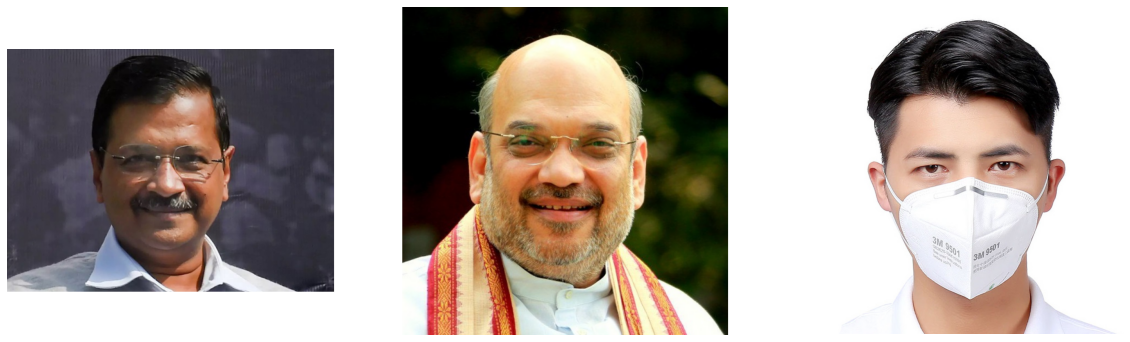

In [7]:
# Display Images 
plt.figure(figsize = (20,15))
plt.subplot(131); plt.imshow(im1Display); plt.axis('off');
plt.subplot(132); plt.imshow(im2Display); plt.axis('off');
plt.subplot(133); plt.imshow(im3Display); plt.axis('off');

In [8]:
!wget -q http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

In [9]:
# Initialize the dlib facial landmakr detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
# Read array of corresponding points
points1 = fbc.getLandmarks(detector, predictor, img1)
points2 = fbc.getLandmarks(detector, predictor, img2)
points3 = fbc.getLandmarks(detector, predictor, img3)

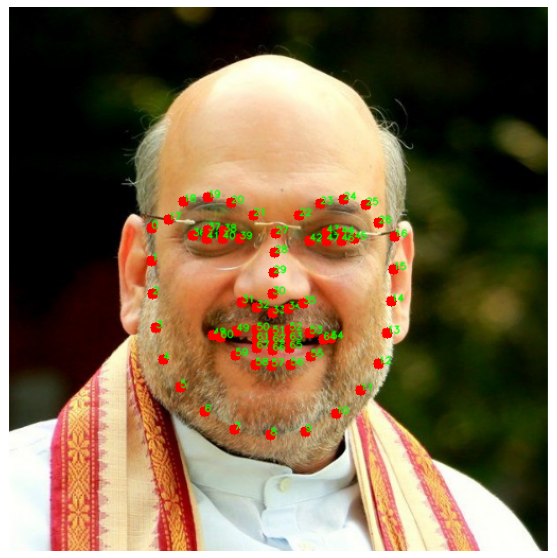

In [10]:
# Display Landmarks
imTemp = im2Display.copy()
idx=0
for p in points2:
    cv2.circle(imTemp, p, 5, (255,0,0), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(imTemp,str(idx),p,font, 0.3, (0, 255, 0), 1, cv2.LINE_AA)
    idx+=1

plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

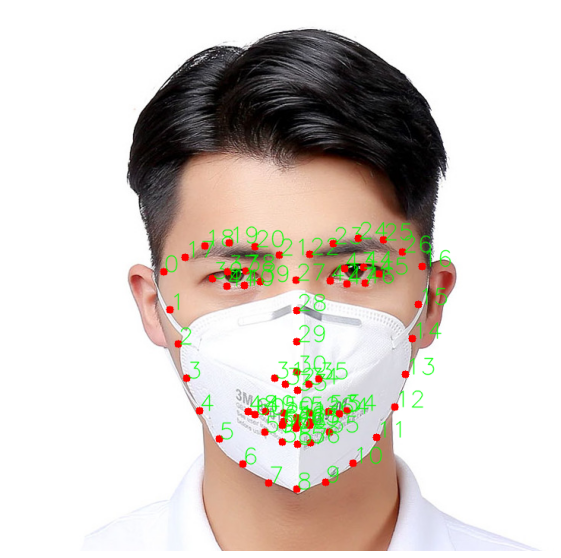

In [11]:
# Display Landmarks
imTemp = im3Display.copy()
idx = 0
for p in points3:
    cv2.circle(imTemp, p, 5, (255,0,0), -1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(imTemp,str(idx),p,font, 1, (0, 255, 0), 1, cv2.LINE_AA)
    idx+=1

plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

In [12]:
points3_new = points3[2:16]

In [13]:
# Find convex hull
# hullIndex = cv2.convexHull(np.array(points3_new), returnPoints=False)

# Create convex hull lists
hull1 = points1[1:16]
hull2 = points2[1:16]
hull3 = points3[1:16]
# for i in range(0, len(hullIndex)):
#     hull1.append(points1[hullIndex[i][0]])
#     hull2.append(points2[hullIndex[i][0]])
#     hull3.append(points3[hullIndex[i][0]])

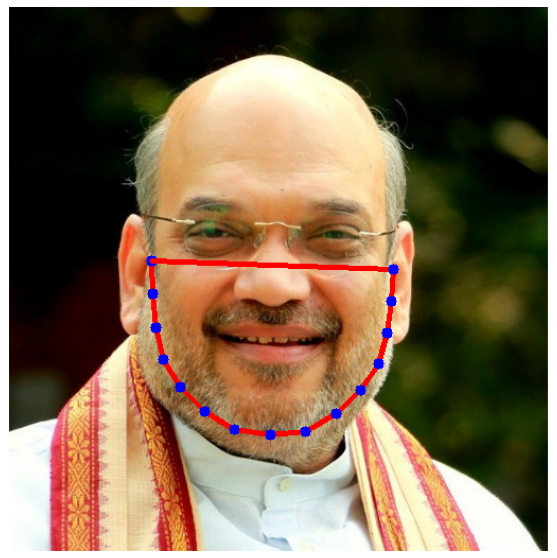

In [14]:
# Display Convex Hull
imTemp = im2Display.copy()
numPoints = len(hull2)
for i in range(0, numPoints):
    cv2.line(imTemp, hull2[i], hull2[(i+1)%numPoints], (255,0,0), 3)
    cv2.circle(imTemp, hull2[i], 5, (0,0,255), -1)
plt.figure(figsize = (20,10)); plt.imshow(imTemp); plt.axis('off');

In [15]:
# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(img2.shape, dtype=img2.dtype) 
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10']/m['m00']), int(m['m01']/m['m00']))

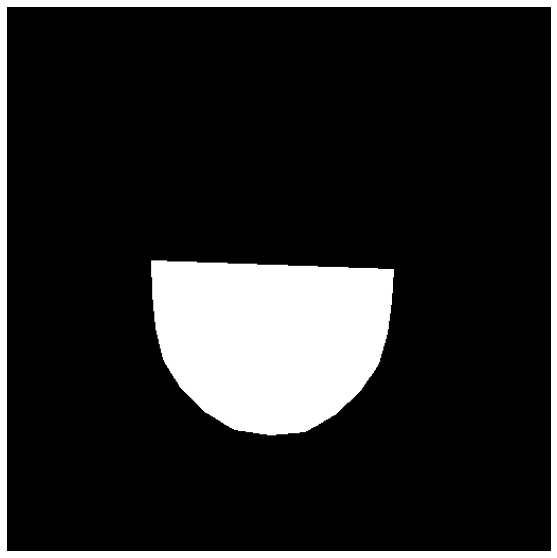

In [16]:
# Display Mask
plt.figure(figsize = (20,10)); plt.imshow(mask); plt.axis('off');

In [17]:
# Find Delaunay traingulation for convex hull points
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])

dt = fbc.calculateDelaunayTriangles(rect, hull2)

# If no Delaunay Triangles were found, quit
if len(dt) == 0:
    quit()

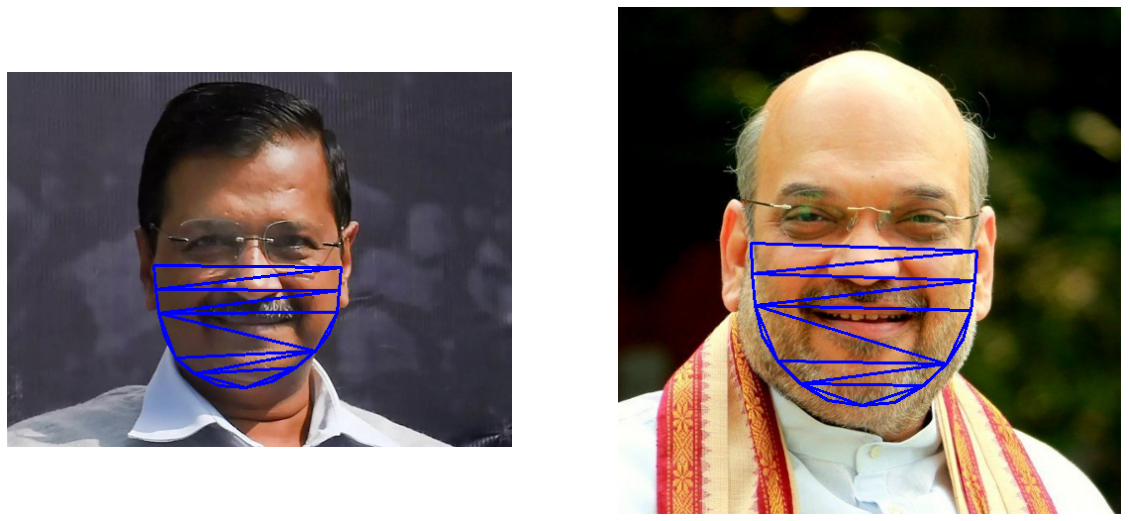

In [18]:
imTemp1 = im1Display.copy()
imTemp2 = im2Display.copy()

tris1 = []
tris2 = []
for i in range(0, len(dt)):
    tri1 = []
    tri2 = []
    for j in range(0, 3):
        tri1.append(hull1[dt[i][j]])
        tri2.append(hull2[dt[i][j]])

    tris1.append(tri1)
    tris2.append(tri2)

cv2.polylines(imTemp1,np.array(tris1),True,(0,0,255),2);
cv2.polylines(imTemp2,np.array(tris2),True,(0,0,255),2);

# Display Triangulation
plt.figure(figsize = (20,10)); 
plt.subplot(121); plt.imshow(imTemp1); plt.axis('off');
plt.subplot(122); plt.imshow(imTemp2); plt.axis('off');

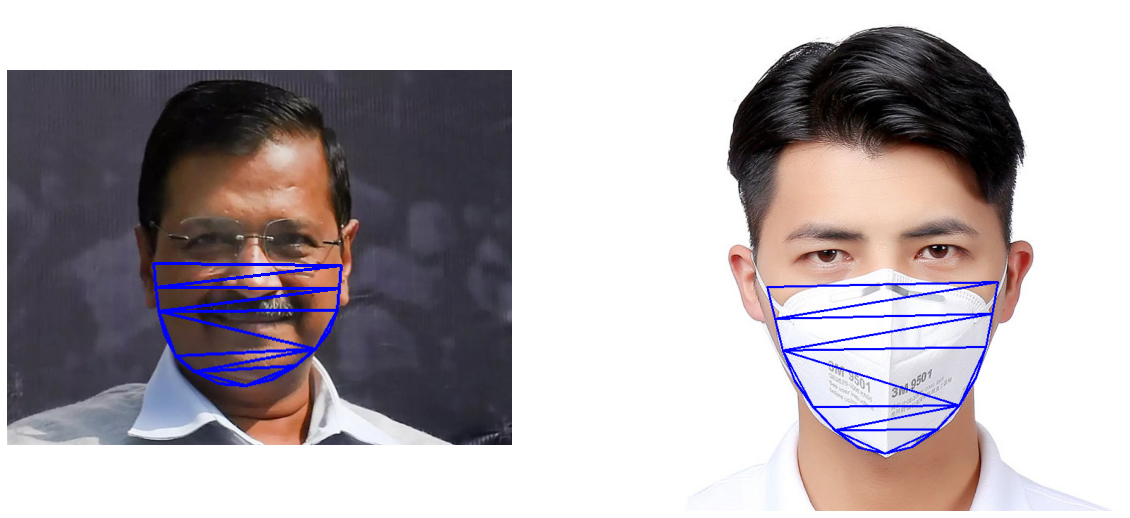

In [19]:
imTemp1 = im1Display.copy()
imTemp3 = im3Display.copy()

tris1 = []
tris3 = []
for i in range(0, len(dt)):
    tri1 = []
    tri3 = []
    for j in range(0, 3):
        tri1.append(hull1[dt[i][j]])
        tri3.append(hull3[dt[i][j]])

    tris1.append(tri1)
    tris3.append(tri3)

cv2.polylines(imTemp1,np.array(tris1),True,(0,0,255),2);
cv2.polylines(imTemp3,np.array(tris3),True,(0,0,255),2);

# Display Triangulation
plt.figure(figsize = (20,10)); 
plt.subplot(121); plt.imshow(imTemp1); plt.axis('off');
plt.subplot(122); plt.imshow(imTemp3); plt.axis('off');

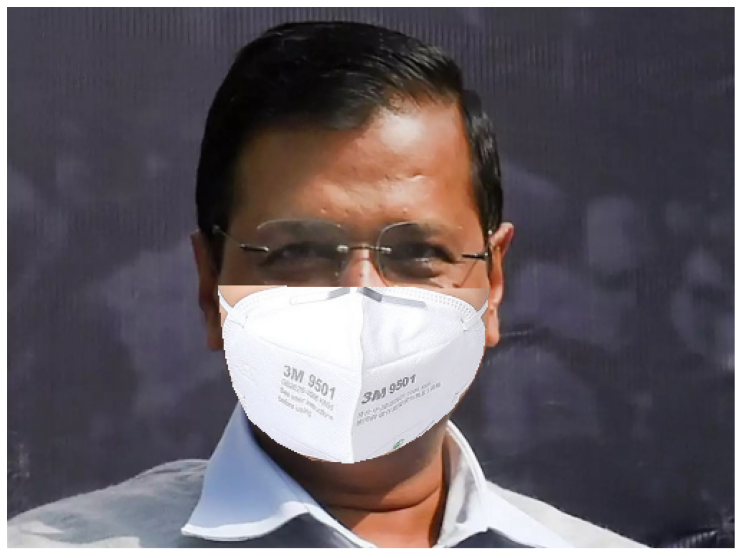

In [20]:
# Simple Alpha Blending
# Apply affine transformation to Delaunay triangles
for i in range(0, len(tris3)):
    fbc.warpTriangle(img3, img1Warped, tris3[i], tris1[i])

plt.figure(figsize=(20,10));
plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');

In [21]:
# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull1)):
    hull8U.append((hull1[i][0], hull1[i][1]))

mask = np.zeros(img1.shape, dtype=img1.dtype) 
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10']/m['m00']), int(m['m01']/m['m00']))

In [22]:
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), img1, mask, center, cv2.NORMAL_CLONE)

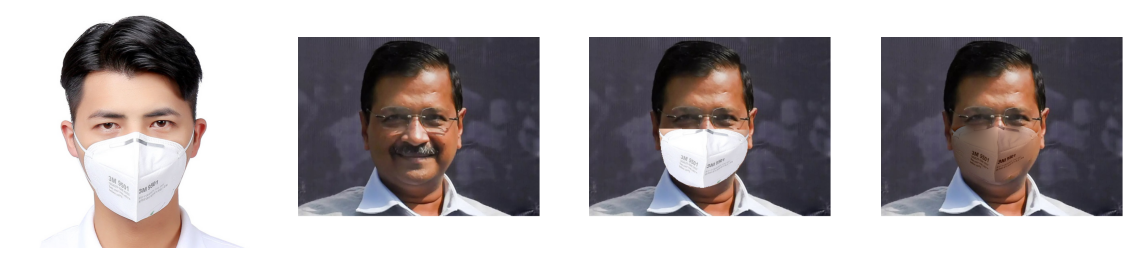

In [23]:
plt.figure(figsize=(20,10))
plt.subplot((141)); plt.imshow(np.uint8(img3)[:,:,::-1]); plt.axis('off');
plt.subplot((142)); plt.imshow(np.uint8(img1)[:,:,::-1]); plt.axis('off');
plt.subplot((143)); plt.imshow(np.uint8(img1Warped)[:,:,::-1]); plt.axis('off');
plt.subplot((144)); plt.imshow(output[:,:,::-1]); plt.axis('off');

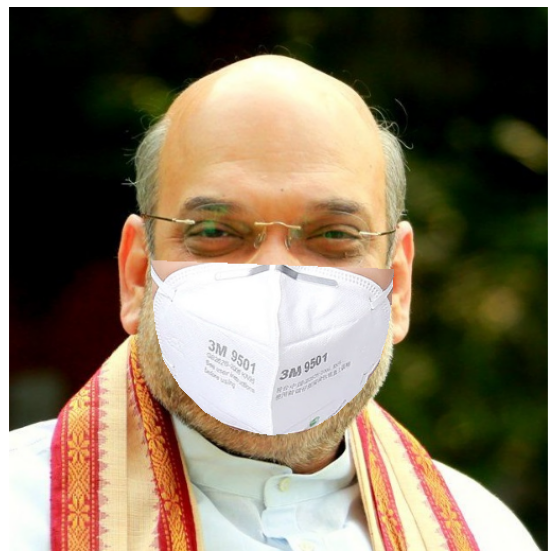

In [24]:
# Simple Alpha Blending
# Apply affine transformation to Delaunay triangles
for i in range(0, len(tris3)):
    fbc.warpTriangle(img3, img2Warped, tris3[i], tris2[i])

plt.figure(figsize=(20,10));
plt.imshow(np.uint8(img2Warped)[:,:,::-1]); plt.axis('off');

In [25]:
# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(img2.shape, dtype=img2.dtype) 
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10']/m['m00']), int(m['m01']/m['m00']))

In [27]:
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img2Warped), img2, mask, center, cv2.NORMAL_CLONE)

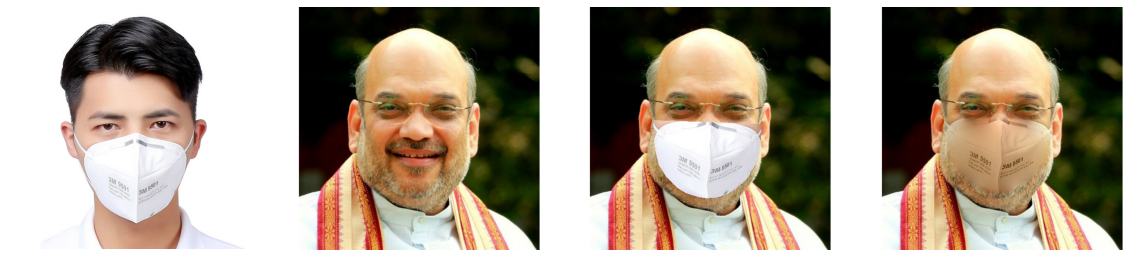

In [28]:
plt.figure(figsize=(20,10))
plt.subplot((141)); plt.imshow(np.uint8(img3)[:,:,::-1]); plt.axis('off');
plt.subplot((142)); plt.imshow(np.uint8(img2)[:,:,::-1]); plt.axis('off');
plt.subplot((143)); plt.imshow(np.uint8(img2Warped)[:,:,::-1]); plt.axis('off');
plt.subplot((144)); plt.imshow(output[:,:,::-1]); plt.axis('off');